<a href="https://colab.research.google.com/github/Zyuuu-G/ML-classwork/blob/main/HW3_Trees_on_the_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHYS 453, Spring 2023



Ziyu Gao

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# HW3 - Trees on the Titanic

Classify the people in data set and tell me **WHO LIVES AND WHO DIES**.

## Assignment:
1.  Train a tree using all the data with max_depth=3 and print a nice diagram of the tree.  Make sure it is filled and all features and classes are labeled!
1.  Set up a test/train split. Train decision trees on the Titanic data to make a plot of test score vs max_depth for depths from 1 to 25.
1.  Use the **best** tree to classify the extra passengers.   


Use the code below to load data without modifications.

In [ ]:
# Load Titanic
data = fetch_openml(name="titanic",version=1, as_frame=True)

df_raw = data.frame # the raw data
df_raw.head()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


This dataset is fascinating.  Let's look at a few columns:
* pclass = Passenger Class 1, 2, or 3
* survived = 1 for people who survived, they will have a lifeboat number in boat and the body column should be blank.  Not all bodies are recovered.
* sibsp = number of siblings (for kids) or spouses (for adults) aboard
* parch = number of parents (for kids) or children (for adults) aboard
* fare is in old British money (pounds / shillings / pence) which gives weird fractions

Notice the tradegies we see in the first 5 rows alone.  Miss Allen (row 0) is a first-class passenger traveling alone who survives.  Next we get the Allison family of four (rows 1-4).  The parents each have 1 spouse (sibsp) and 2 children (parch) aboard, the kids each have 1 sibling and 2 parents.  Only the 11-month old infant is put on a lifeboat and survives.

To use this for machine learning, we need to clean this up significantly:
* Throw away some columns
* Make all columns numeric
* Remove rows with missing data



In [ ]:
# Factorize any non-numeric columns we want to use
codes, genders = pd.factorize(df_raw.sex)
df_raw['gender'] = codes
print('Gender codes:', genders.categories)

Gender codes: Index(['female', 'male'], dtype='object')


In [ ]:
# Choose columns to keep
df_raw.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'gender'],
      dtype='object')

In [ ]:
features = ['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare'] # choose columns for features
target = ['survived']
cols = target + features # combination of target and features
df = df_raw[cols].copy()
df.head()

,survived,pclass,gender,age,sibsp,parch,fare
0,1,1.0,0,29.0000,0.0,0.0,211.3375
1,1,1.0,1,0.9167,1.0,2.0,151.5500
2,0,1.0,0,2.0000,1.0,2.0,151.5500
3,0,1.0,1,30.0000,1.0,2.0,151.5500
4,0,1.0,0,25.0000,1.0,2.0,151.5500


In [ ]:
df.describe()

,pclass,gender,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.644003,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.478997,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


WARNING!  The count is different for different columns.  We must have some missing data!

In [ ]:
# Clean up dataframe by dropping missing rows
print('Row count:\t', len(df))
df.dropna(inplace=True)  # delete rows with missing or bad values
print('After dropna:\t', len(df))

Row count:	 1309
After dropna:	 1045


In [ ]:
# Save variables
X = df[features].values
y = df[target].values

# Load passenger data

In [ ]:
df_pass = pd.read_csv('https://raw.githubusercontent.com/mdaugherity/MachineLearning2023/main/titanic_passengers.csv')
df_pass

,Name,pclass,gender,age,sibsp,parch,fare
0,Dawson,3,1,49,3,3,58.5
1,Ziyu,2,1,83,4,1,60.5
2,Colton,3,1,21,0,0,1.0
3,Kathryn,2,0,20,1,3,200.0
4,Mirimo,1,1,36,3,0,300.0
5,Sidney,3,1,26,0,0,0.0
6,Justin,1,1,76,4,1,77.0
7,Mike,1,1,99,1,17,250.0


In [ ]:
X_pred = df_pass[features] # make sure we get the same feature columns in the same order
X_pred

,pclass,gender,age,sibsp,parch,fare
0,3,1,49,3,3,58.5
1,2,1,83,4,1,60.5
2,3,1,21,0,0,1.0
3,2,0,20,1,3,200.0
4,1,1,36,3,0,300.0
5,3,1,26,0,0,0.0
6,1,1,76,4,1,77.0
7,1,1,99,1,17,250.0


# Problem 1

In [ ]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X,y)

DecisionTreeClassifier(max_depth=3)

In [ ]:
def make_tree_plots(depth):
    """Makes a new tree of a fixed depth, then plots the tree structure and decision boundary"""
    plt.figure(figsize=(20,10))

    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, y)
    tree.plot_tree(clf, filled=True, class_names=['0', '1', '2'])

    plt.show()

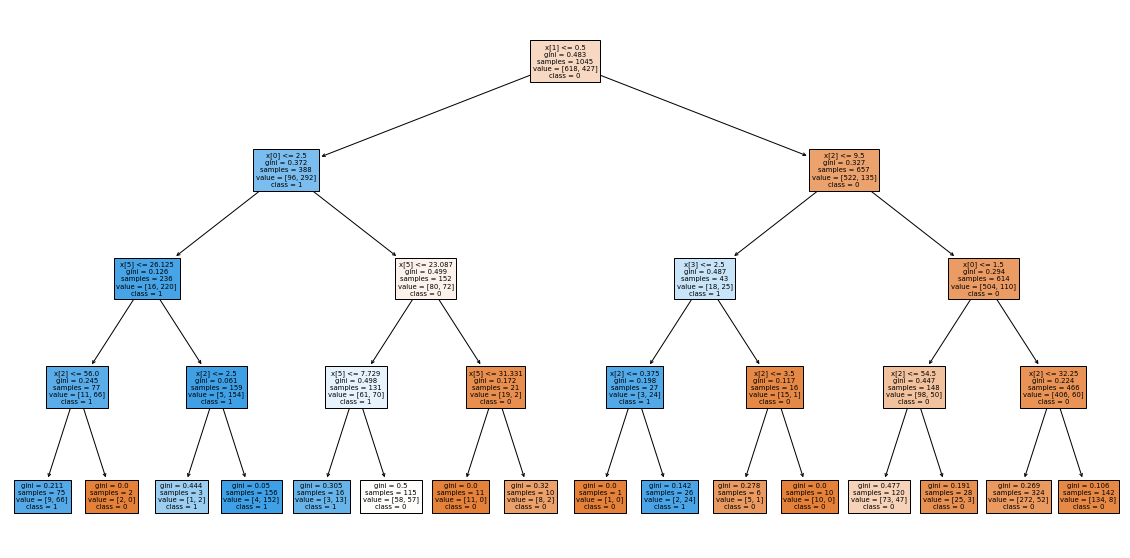

In [ ]:
make_tree_plots(4)

*DISCUS YOUR RESULTS HERE*

# Problem 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

(1045, 6)


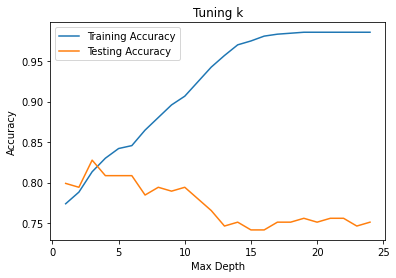

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=3)
print(X.shape)

KLIST = np.arange(1,25)

train_scores = []
test_scores = []
for k in KLIST:
  clf = tree.DecisionTreeClassifier(max_depth=k)
  clf.fit(X_train,y_train)

  test_score = clf.score(X_test,y_test)
  train_score = clf.score(X_train,y_train)
  #print(k, train_score, test_score)
  train_scores.append(train_score)
  test_scores.append(test_score)

plt.plot(KLIST, train_scores, label='Training Accuracy')
plt.plot(KLIST, test_scores, label='Testing Accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Tuning k')
plt.show()

*DISCUS YOUR RESULTS HERE*

# Problem 3

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X,y)

DecisionTreeClassifier(max_depth=3)

In [ ]:
y_pred = clf.predict(X_pred)
print(y_pred)

['0' '0' '0' '1' '0' '0' '0' '0']


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


*DISCUS YOUR RESULTS HERE*